# **Module 3: AI tools**
## DAT410

### Group 29 

We hereby declare that we have both actively participated in solving every exercise. All solutions are entirely our own work, without having taken part of other solutions.

___


## 1) Article summary and take-aways

The article talks about technical debt, specifically in machine learning. They argue that ML system has a special capacity to incur technical debt. It mentions different aspects of this. 

In the section (2 Complex Models Erode Boundaries) we particilarly thought that the examples of Correction Cascaces and Undeclared customers were interesting. 

In the section (3 Data Dependencies Cost More than Code Dependecies) it mentions how some unstable or underitilized data dependenencies can be detremental in the long term. 

In the section (4 Feedback Loops) it talks about how some aspects of a system may influence the functionality of others without the direct knowledge of the developers. We particularly thought that the example of how different recommendation systems on a website could influence eachother was interesting.

Section (5 ML-System Anti-Patterns) talks about the importance of abstraction and structure when writing ML code. How package structure and code visibility can be important, and gives examples of certain pitfalls that can happen when implemnented correctly or when the code is worked on by different people with different underlying knowledge of the previous implementations.

In section (6 Configuration Debt) the article gives examples of how the imporance of proper configuration of ML projects/implementations. It should be easy for a new user to make changes to the configuration and recognize the differences in configurations, while reducing the amounts of possible errors that can be made, while also easing the regonition of these potential errors.

The Section (7 Dealing with changes in the external world) mentions several ideas on how to keep a system ready for change in the external world, and how to test the system so that the developers are able to properly adapt the system to the changes.

(8 Other Areas of ML-related Debt) highlights some other important things like Rerproducability-, Procces Management, and Cultural Debt.

In the last conclusion chapter they discuss how to look at technical debt in ML systems and they mention that they hope the paper can help aid in engineers having the ability to create more maintainable and sustainable systems.

Our takaways were mainly the importance of considering many aspects on how the ML code/system is integreated with the data and the world around it. To always keep in mind that for code to be usable by future engineers, or the developers themselves in the future, it is important that things are clear, structured, and that the system dependencies are well thought out. Sometimes things can influence eachother without our knowledge, and that can be a detrement to the system.

___
## 2/3) Implementation/Discussion


We use the Beijing data for training and the Shenyang data for validation. In order to increase the accuracy of our k-means classification we implemented majority vote in the fit function.


At first we noticed that we got the highest accuracy by using two clusters, but upon investigation we realized that his was because our model was predicting all labels as non-polluted (see the confusion matrix below, all labels are zero), due to the nature of our implementation. To avoid this we used F1-scoring in order to figure out which amount of clusters worked best for our data. We plotted a graph that can be seen below, and we observed that any amount of clusters above the 30-range would render about the same F1 score and accuracy. In the end we chose to go with 45 clusters.


In the end we feel that our system did quite okay. We achieved out highest improvement in accuracy by implementing majority vote. However we feel that there are some innate constraints when attempting to make these type of predictions. We are attempting to predict the pollution of other cities by just training on one city, Beijing, and validating through Shenyen. Then we are using this model on three other cities. These cities are located in different places and have different climates, temperatures, weather patterns, etc… There are very many factors that could effect this, that are also not included in the data. We are also limited by using kmeans clustering. So with this into consideration we feel that our scores are quite sufficient.


This model would not work very well at all on European cities for example, and even less on lower populated cities because of their general lower pollution levels. If we had more data such as population amount, country or region, culture, population density, etc we could for example make better predictions on cities in general.


We achieved about the same accuracy for the validation data, training data and the test cities, which would hopefully imply that we did not over-tune the model for our training data or validation data. The accuracies of our training, validation, and other cities can be seen below.


In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in the data

beijing_data = pd.read_csv("Beijing_labeled.csv")
chengdu_data = pd.read_csv('Chengdu_labeled.csv')
guangzhou_data = pd.read_csv('Guangzhou_labeled.csv')
shanghai_data = pd.read_csv('Shanghai_labeled.csv')
shenyang_data = pd.read_csv('Shenyang_labeled.csv')

In [3]:
# Preprocessing 
X_train = beijing_data.copy().drop('PM_HIGH', axis=1) #features
y_train = beijing_data.copy()['PM_HIGH'].astype(int) #labels

X_val = shenyang_data.copy().drop('PM_HIGH', axis=1)
y_val = shenyang_data.copy()['PM_HIGH'].astype(int)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Use the same scaler to transform validation data

In [4]:
class Classifier:
    def __init__(self, n_clusters=2):
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
        self.cluster_labels = None

    def fit(self, X, y):
        # Fit the classifier
        self.kmeans.fit(X)
        self.cluster_labels = np.zeros(self.kmeans.n_clusters, dtype=int)
        
        for i in range(self.kmeans.n_clusters):
            """ 
            Assign labels to clusters based on majority vote

            - Segment the training data into clusters.

            - For each cluster, figure out which label (0 for low pollution, 1 for high pollution) 
            is most common among the data points in that cluster.

            -Assign this most common label to the cluster itself, effectively "labeling" 
            the cluster based on the predominant label of its members.
            """
            # Find the index of points in cluster i
            indexes = np.where(self.kmeans.labels_ == i)[0]
            
            # Assign the majority label to the cluster
            cluster_label = np.bincount(y[indexes]).argmax()
            self.cluster_labels[i] = cluster_label

    def predict(self, X):
        # Predict the labels
        cluster_indexes = self.kmeans.predict(X)
        return np.array([self.cluster_labels[i] for i in cluster_indexes])
    
    def score(self, X, y):
        # Score the classifier
        predictions = self.predict(X)
        return np.mean(predictions == y)
    
    def f1_score(self, X, y):
        # F1 score
        predictions = self.predict(X)
        tp = np.sum((predictions == 1) & (y == 1))
        fp = np.sum((predictions == 1) & (y == 0))
        fn = np.sum((predictions == 0) & (y == 1))
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        return 2 * precision * recall / (precision + recall)
        
    def conf_mat(self, X, y):
        # Confusion matrix

        predictions = self.predict(X)
        
        matrix = confusion_matrix(predictions, y)
        
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    
    

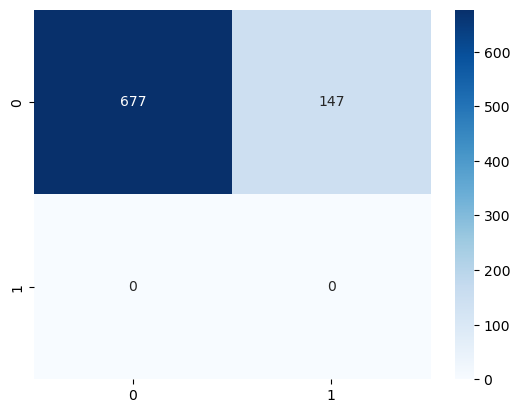

In [5]:
classifier_2clusters = Classifier(n_clusters=2)
classifier_2clusters.fit(X_train_scaled, y_train)
classifier_2clusters.conf_mat(X_val_scaled, y_val)

Confusion matrix with 2 k-means clusters, showing that all predicted labels are 0.

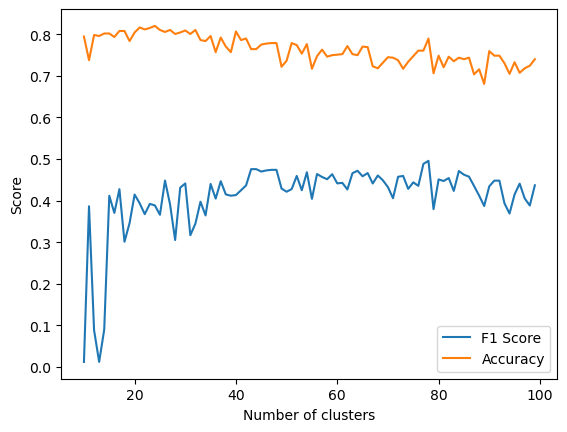

In [6]:
# Find out which amount of clusters has the highest F1 score, plot the results
f1_scores = []
accuracy = []

for n_clusters in range(10, 100):
    classifier_test = Classifier(n_clusters=n_clusters)
    classifier_test.fit(X_train_scaled, y_train)
    accuracy.append(classifier_test.score(X_val_scaled, y_val))
    f1_scores.append(classifier_test.f1_score(X_val_scaled, y_val))

plt.plot(range(10, 100), f1_scores, label='F1 Score')
plt.plot(range(10, 100), accuracy, label='Accuracy')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

We use k=45 from now on.

In [7]:
classifier = Classifier(n_clusters=45)
classifier.fit(X_train_scaled, y_train)
print("Training Accuracy: ", classifier.score(X_train_scaled, y_train), "\tF1 Score: ", classifier.f1_score(X_train_scaled, y_train))
print("Validation Accuracy: ", classifier.score(X_val_scaled, y_val), "\tF1 Score: ", classifier.f1_score(X_val_scaled, y_val))

Training Accuracy:  0.7648478995654273 	F1 Score:  0.5890295358649789
Validation Accuracy:  0.7754854368932039 	F1 Score:  0.4699140401146132


In [8]:
# Score for the other cities
X_val = chengdu_data.copy().drop('PM_HIGH', axis=1)
y_val = chengdu_data.copy()['PM_HIGH'].astype(int)
X_val_scaled = scaler.transform(X_val)
print("Chengdu Accuracy: ", classifier.score(X_val_scaled, y_val))

X_val = guangzhou_data.copy().drop('PM_HIGH', axis=1)
y_val = guangzhou_data.copy()['PM_HIGH'].astype(int)
X_val_scaled = scaler.transform(X_val)
print("Guangzhou Accuracy: ", classifier.score(X_val_scaled, y_val))

X_val = shanghai_data.copy().drop('PM_HIGH', axis=1)
y_val = shanghai_data.copy()['PM_HIGH'].astype(int)
X_val_scaled = scaler.transform(X_val)
print("Shanghai Accuracy: ", classifier.score(X_val_scaled, y_val))

Chengdu Accuracy:  0.6594594594594595
Guangzhou Accuracy:  0.7633136094674556
Shanghai Accuracy:  0.6491487786824575
